In [106]:
import sys, os
from pyprojroot import here


# spyder up to find the root

local = here(project_files=[".local"])

# append to path
sys.path.append(str(local))

In [107]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import optax
import pyinterp
import equinox as eqx
from einops import rearrange
import numpy as np
import xarray as xr
import pandas as pd

import tqdm.notebook as tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import hvplot.xarray
from xmovie import Movie
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

from src.data import make_mini_batcher
from src.mlp import MLPNet
from src.siren import SirenNet
from src.stats import calculate_nrmse, compute_ts_stats
from src.utils import get_meshgrid, calculate_gradient, calculate_laplacian
from src.psd import select_track_segments, find_wavelength_crossing, compute_psd_scores
from src.viz import plot_psd_spectrum, plot_psd_score

import wandb

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 152, in check_network_status
    status_response = self._interface.communicate_network_status()
  File "/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/wandb/sdk/interface/interface.py", line 125, in communicate_network_status
    resp = self._communicate_network_status(status)
  File "/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/wandb/sdk/interface/interface_shared.py", line 405, in _communicate_network_status
    resp = self._communicate(req, local=True)
  File "/home/johnsonj/miniconda3/envs/ja

In [3]:
wandb.init(
    tags=["investigation"],
    project="nerf4ssh",
    entity="ige",
    dir=local,
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: emanjohnson91 (use `wandb login --relogin` to force relogin)
wandb: WARNING Invalid value for property root_dir: /home/johnsonj/projects/gps4oi/notebooks/nerf. This will raise an error in the future.
2022-05-04 08:44:01.572210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [4]:
smoke_test = False
wandb.config.update({"smoke_test": smoke_test})

In [5]:
!ls /mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf

model.nc  test.nc  train.nc


In [6]:
dataset = "ssh_gulf_winter"

if dataset == "ssh_gulf_winter":
    img = xr.open_dataset("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf_winter/train.nc")
elif dataset == "ssh_gulf_summer":
    img = xr.open_dataset("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf_summer/train.nc")
elif dataset == "ssh_gulf":
    img = xr.open_dataset("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf/train.nc")
else:
    raise ValueError(f"Unrecognized dataset: {dataset}")

wandb.config.update({"dataset": dataset})

In [7]:
# slice_start = 300
# slice_end = 400
# img = img.p.isel(steps=slice(slice_start, slice_end))

# wandb.config.update(
#     {
#         "dataset": "ssh",
#         "region": "gulf",
        
#         # "slice_start":  slice_start,
#         # "slice_end": slice_end,
#     }
# )

# # coarsen time domain
# train_coarsen_steps = 10
# train_coarsen_Nx = 4
# train_coarsen_Ny = 4
# img = img.coarsen(steps=train_coarsen_steps, boundary="trim").mean()


# # coarsen space domain
# img = img.coarsen(Nx=train_coarsen_Nx, Ny=train_coarsen_Ny, boundary="trim").mean()
# wandb.config.update(
#     {
#         "train_coarsen_steps": train_coarsen_steps, 
#         "train_coarsen_Nx": train_coarsen_Nx, 
#         "train_coarsen_Ny": train_coarsen_Ny,
#         "train_Nx": img.coords["Nx"].shape[0],
#         "train_Ny": img.coords["Ny"].shape[0],
#         "train_Nt": img.coords["steps"].shape[0],
#     }
# )

# img

In [8]:
# img.hvplot.image(x="Nx", y="Ny", width=500, height=400, cmap="RdBu_r", title="Ground Truth")

In [9]:
# img.hvplot.quadmesh(x="longitude", y="latitude", width=500, height=400, cmap="RdBu_r", title="Ground Truth")

In [10]:
# convert to dataframe
data = img.to_dataframe().reset_index().dropna()
data.head()

,time,longitude,latitude,sla_unfiltered
0,2015-12-01 00:25:31.702877184,294.025210,42.190078,0.024
1,2015-12-01 00:25:32.781457152,294.063017,42.141874,0.032
2,2015-12-01 00:25:33.860037120,294.100760,42.093655,0.089
3,2015-12-01 00:25:34.938617088,294.138440,42.045419,0.092
4,2015-12-01 00:25:36.017197056,294.176056,41.997167,0.014


In [11]:
mask_internal = False
data["mask"] = 0
wandb.config.update({"mask_internal": mask_internal})

if mask_internal:
    # values within the boundaries
    
    filter1 = data["steps"] < 1.0
    filter2 = data["steps"] > 0.0
    conditions = [
        (data["steps"] < 1.0),
        (data["steps"] > 0.0)
    ]
    choices = [1, 0]
    data["mask"] = np.select(conditions, choices)



In [12]:
# data["time"]

**TODO**: Figure out the min-max bounds.


```python
t0 = pd.DatetimeIndex([pd.Timestamp("1993-01-01")]).to_julian_date()
tmax = pd.DatetimeIndex([pd.Timestamp("2023-01-01")]).to_julian_date()
```

In [13]:
# hard-code min/max dates
t0 = pd.DatetimeIndex([
    pd.Timestamp(
        year=2015, 
        month=1, 
        day=1,
        hour=1,
        minute=None,
        second=None
    )]).to_julian_date()
tmax = pd.DatetimeIndex([
    pd.Timestamp(
        year=2020, 
        month=1, 
        day=1,
        hour=1,
        minute=None,
        second=None
    )]).to_julian_date()



In [14]:
# scale between min-max
def f(x):
    return (x - t0) / (tmax - t0)

# def f_deduct(x):
#     return x - t0
# def f(x):
#     return (x - t0) / (tmax - t0)

In [15]:
t0, tmax

(Float64Index([2457023.5416666665], dtype='float64'),
 Float64Index([2458849.5416666665], dtype='float64'))

In [16]:
pd.DatetimeIndex(data['time']).to_julian_date()[0], pd.DatetimeIndex(data['time']).to_julian_date()[-1]

(2457357.517728043, 2457449.445542938)

In [17]:
f(pd.DatetimeIndex(data['time']).to_julian_date()[0]), f(pd.DatetimeIndex(data['time']).to_julian_date()[-1])

(Float64Index([0.1829003621994947], dtype='float64'),
 Float64Index([0.2332441819669028], dtype='float64'))

In [18]:


data["time_julian"] = f(pd.DatetimeIndex(data['time']).to_julian_date())


data.head()

,time,longitude,latitude,sla_unfiltered,mask,time_julian
0,2015-12-01 00:25:31.702877184,294.025210,42.190078,0.024,0,0.1829
1,2015-12-01 00:25:32.781457152,294.063017,42.141874,0.032,0,0.1829
2,2015-12-01 00:25:33.860037120,294.100760,42.093655,0.089,0,0.1829
3,2015-12-01 00:25:34.938617088,294.138440,42.045419,0.092,0,0.1829
4,2015-12-01 00:25:36.017197056,294.176056,41.997167,0.014,0,0.1829


In [19]:
data.time.describe()

/tmp/ipykernel_11433/1766826939.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.time.describe()


count                             51478
unique                            51478
top       2016-02-24 11:42:28.210011904
freq                                  1
first     2015-12-01 00:25:31.702877184
last      2016-03-01 22:41:34.909846016
Name: time, dtype: object

In [20]:
# # transform time coordinate
# days_in_year = 365
# year = pd.to_datetime(data['time']).dt.dayofyear
# data["doy_sin"] = np.sin(2.0 * np.pi * year / days_in_year)
# data["doy_cos"] = np.cos(2.0 * np.pi * year / days_in_year)

# # transform time coordinate
# num_of_years = 5
# year = pd.to_datetime(data['time']).dt.year
# data["year_sin"] = np.sin(2.0 * np.pi * (year - 2010) / num_of_years)
# data["year_cos"] = np.cos(2.0 * np.pi * (year - 2010) / num_of_years)

In [21]:
data.describe()

,longitude,latitude,sla_unfiltered,mask,time_julian
count,51478.000000,51478.000000,51478.000000,51478.0,51478.000000
mean,299.902045,37.995121,0.112117,0.0,0.207954
std,3.435650,3.453719,0.225815,0.0,0.014608
min,294.001179,32.000381,-1.029000,0.0,0.182900
25%,296.933520,35.028749,0.017000,0.0,0.195431
50%,299.781110,37.956215,0.119000,0.0,0.207872
75%,302.832549,41.016772,0.237000,0.0,0.220952
max,305.999920,43.999704,0.987000,0.0,0.233244


In [22]:
# transform time coordinates
cols = ["time_julian", "longitude", "latitude"]
var_cols = ["sla_unfiltered"] 
time_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(data[cols].values)
data[cols] = time_scaler.transform(data[cols].values).squeeze()

data.describe()

,longitude,latitude,sla_unfiltered,mask,time_julian
count,51478.000000,51478.000000,51478.000000,51478.0,51478.000000
mean,-0.016419,-0.000820,0.112117,0.0,-0.004679
std,0.572668,0.575652,0.225815,0.0,0.580347
min,-1.000000,-1.000000,-1.029000,0.0,-1.000000
25%,-0.511225,-0.495244,0.017000,0.0,-0.502195
50%,-0.036577,-0.007305,0.119000,0.0,-0.007970
75%,0.472049,0.502817,0.237000,0.0,0.511689
max,1.000000,1.000000,0.987000,0.0,1.000000


In [23]:
data.head()

,time,longitude,latitude,sla_unfiltered,mask,time_julian
0,2015-12-01 00:25:31.702877184,-0.995994,0.698379,0.024,0,-1.000000
1,2015-12-01 00:25:32.781457152,-0.989693,0.690344,0.032,0,-1.000000
2,2015-12-01 00:25:33.860037120,-0.983401,0.682307,0.089,0,-0.999999
3,2015-12-01 00:25:34.938617088,-0.977121,0.674267,0.092,0,-0.999999
4,2015-12-01 00:25:36.017197056,-0.970851,0.666225,0.014,0,-0.999999


In [24]:
x = data[data["mask"].isin([0])][cols].values
y = data[data["mask"].isin([0])][var_cols].values



x.shape, y.shape

((51478, 3), (51478, 1))

In [25]:
# split training and testing
train_size = 0.9
idx_train, idx_valid = train_test_split(data[data["mask"].isin([0])].index.values, train_size=train_size, random_state=123)

# # split training and validation
# idx_train, idx_valid = train_test_split(idx_train, test_size=0.1, random_state=123)

In [26]:
data["split"] = 0
data.loc[idx_train, "split"] = 1
data.loc[idx_valid, "split"] = 2
# data.loc[idx_test, "split"] = 3
data.head()

,time,longitude,latitude,sla_unfiltered,mask,time_julian,split
0,2015-12-01 00:25:31.702877184,-0.995994,0.698379,0.024,0,-1.000000,1
1,2015-12-01 00:25:32.781457152,-0.989693,0.690344,0.032,0,-1.000000,2
2,2015-12-01 00:25:33.860037120,-0.983401,0.682307,0.089,0,-0.999999,1
3,2015-12-01 00:25:34.938617088,-0.977121,0.674267,0.092,0,-0.999999,1
4,2015-12-01 00:25:36.017197056,-0.970851,0.666225,0.014,0,-0.999999,1


In [27]:
xtrain = jnp.array(data[data["split"].isin([1])][cols].values)
ytrain = jnp.array(data[data["split"].isin([1])][var_cols].values)
xvalid = jnp.array(data[data["split"].isin([2])][cols].values)
yvalid = jnp.array(data[data["split"].isin([2])][var_cols].values)
# xtest = jnp.array(data[data["split"].isin([3])][cols].values)
# ytest = jnp.array(data[data["split"].isin([3])][var_cols].values)

print(f"# Data: {x.shape[0]:_} \n# Train: {xtrain.shape[0]:_}\n# Valid: {xvalid.shape[0]:_}")

# Data: 51_478 
# Train: 46_330
# Valid: 5_148


In [28]:
xtrain[:10]

DeviceArray([[-1.        , -0.9959944 ,  0.6983786 ],
             [-0.99999946, -0.9834014 ,  0.68230724],
             [-0.99999917, -0.97712076,  0.6742675 ],
             [-0.9999989 , -0.97085077,  0.666225  ],
             [-0.9999986 , -0.96459126,  0.65818006],
             [-0.9999984 , -0.9583423 ,  0.6501324 ],
             [-0.9999981 , -0.952104  ,  0.64208233],
             [-0.99999785, -0.9458762 ,  0.6340293 ],
             [-0.99999756, -0.9396588 ,  0.62597376],
             [-0.99999726, -0.93345183,  0.61791563]], dtype=float32)

In [29]:
wandb.config.update(
    {
        "train_size": train_size,
        # "n_data": x.shape[0],
        "n_train": xtrain.shape[0], 
        "n_valid": xvalid.shape[0],
        # "n_test": xtest.shape[0]
    }
)

In [30]:


init_key = jrandom.PRNGKey(123)
model = "siren"
in_dim = len(cols)
out_dim = 1
hidden_dim = 256
n_hidden = 5

wandb.config.update(
    {
        "model": model,
        "in_dim": in_dim,
        "out_dim": out_dim,
        "hidden_dim": hidden_dim,
        "n_hidden": n_hidden
    }
)


# SIMPLE MLP
if model == "mlp":
    model = MLPNet(
        in_dim=in_dim,
        out_dim=out_dim,
        hidden_dim=hidden_dim, 
        n_hidden=n_hidden, 
        key=init_key
    )

    wandb.config.update(
        {
            "activation": "relu", 
        }
    )
    
elif model == "siren":

    # SIREN MODEL
    w0_initial = 30.0
    w0 = 1.0
    final_scale = 1.0

    model = SirenNet(
        in_dim=in_dim,
        out_dim=out_dim,
        hidden_dim=hidden_dim, 
        n_hidden=n_hidden,
        w0=w0,
        w0_initial=w0_initial,
        final_scale=final_scale,
        key=init_key
    )

    wandb.config.update(
        {
            "w0_initial": w0_initial,
            "w0": w0, 
            "final_scale": final_scale,
        }
    )
else:
    raise ValueError(f"Unrecognized model: {model}")

In [31]:
# model

In [32]:
init_batch = xtrain[:100]
init_out = ytrain[:100]

out = jax.vmap(model)(init_batch)

# check sizes
assert out.shape == init_out.shape

In [33]:
out.shape, init_out.shape

((100, 1), (100, 1))

In [34]:


learning_rate = 1e-4

wandb.config.update(
    {
        "learning_rate": learning_rate,
    }
)


optim = optax.adam(learning_rate)
opt_state = optim.init(model)

In [35]:
@eqx.filter_jit
@eqx.filter_value_and_grad
def make_step(model, x, y):
    pred_y = jax.vmap(model)(x)
    # Trains with respect to binary cross-entropy
    return jnp.mean((pred_y - y)**2)

@eqx.filter_jit
def val_step(model, x, y):
    pred_y = jax.vmap(model)(x)
    # Trains with respect to binary cross-entropy
    return jnp.mean((pred_y - y)**2)
    

In [36]:
# loss, grads = make_step(model, xtrain[idx], ytrain[idx])
# perm = jrandom.permutation(key, indices)

In [37]:

batch_size = 128
steps = 30_000 if not smoke_test else 5_000

wandb.config.update(
    {
        "batch_size": batch_size,
        "steps": steps
    }
)

# keys for the permutations
# loader_key = jrandom.PRNGKey(42)
# indices = jnp.arange(x.shape[0])
# perm = jrandom.split(loader_key, steps)
train_ds = make_mini_batcher(xtrain, ytrain, batch_size, 1, shuffle=True)


losses = {} 
losses["train"] = []
losses["valid"] = []


with tqdm.trange(steps) as pbar:
    for step in pbar:
        
        # idx = jrandom.choice(perm[step], indices, shape=(batch_size,))
        # loss, grads = make_step(model, xtrain[idx], ytrain[idx])k
        
        ix, iy = train_ds()
        loss, grads = make_step(model, ix, iy)
        
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        
        losses["train"].append(loss)
        wandb.log({"train_loss": loss, "iteration": step})
        
        # validation step
        vloss = val_step(model, xvalid, yvalid)
        losses["valid"].append(vloss)
        
        
        wandb.log({"val_loss": vloss, "iteration": step})
        
        if step % 10 == 0:
            pbar.set_description(f"Step: {step:_} | Train Loss: {loss:.3e} | Valid Loss: {vloss:.3e}")
            

2022-05-04 08:44:08.725132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-04 08:44:08.725160: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


  0%|          | 0/30000 [00:00<?, ?it/s]

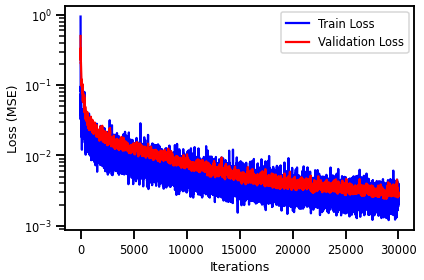

In [38]:
fig, ax = plt.subplots()

ax.plot(losses["train"], label="Train Loss", color="blue")
ax.plot(losses["valid"], label="Validation Loss", color="red")
ax.set(xlabel="Iterations", ylabel="Loss (MSE)", yscale="log")
plt.tight_layout()
plt.legend()
plt.show()

In [39]:
@jax.jit
def pred_step(model, data):
    return jax.vmap(model)(data)

In [40]:
# %%time

# data["pred"] = np.asarray(pred_step(model,jnp.asarray(data[cols].values)))

In [41]:
# data_test["pred"] = np.asarray(pred_step(model,jnp.asarray(data_test[["Nx", "Ny", "steps"]].values)))


## Results

In [42]:
!ls /mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf/

model.nc  test.nc  train.nc


In [43]:
%%time


if dataset == "ssh_gulf_winter":
    img_test = xr.open_dataset("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf_winter/test.nc")
elif dataset == "ssh_gulf_summer":
    img_test = xr.open_dataset("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf_summer/test.nc")
elif dataset == "ssh_gulf":
    img_test = xr.open_dataset("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf/test.nc")
else:
    raise ValueError(f"Unrecognized dataset: {dataset}")


img_test

CPU times: user 16 ms, sys: 12 ms, total: 28 ms
Wall time: 467 ms


<xarray.Dataset>
Dimensions:         (time: 51551)
Coordinates:
  * time            (time) datetime64[ns] 2015-12-01T00:25:31.702877184 ... 2...
    longitude       (time) float64 ...
    latitude        (time) float64 ...
Data variables:
    sla_unfiltered  (time) float32 ...

In [44]:
%%time

# convert to dataframe
data_test = img_test.to_dataframe().reset_index().dropna()

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 113 ms


In [45]:
wandb.config.update(
    {
        "n_test": data_test.shape[0],
    }
)

In [46]:
# # transform time coordinate
# days_in_year = 365
# year = pd.to_datetime(data_test['time']).dt.dayofyear
# data_test["doy_sin"] = np.sin(2.0 * np.pi * year / days_in_year)
# data_test["doy_cos"] = np.cos(2.0 * np.pi * year / days_in_year)
# data_test[cols] = time_scaler.transform(data_test[cols].values).squeeze()

In [47]:
data_test["time_julian"] = f(pd.DatetimeIndex(data_test['time']).to_julian_date())
data_test[cols] = time_scaler.transform(data_test[cols].values).squeeze()

In [48]:
%%time

data_test["pred"] = np.asarray(pred_step(model,jnp.asarray(data_test[cols].values)))


CPU times: user 1.41 s, sys: 128 ms, total: 1.54 s
Wall time: 2.32 s


In [49]:
data_test[cols] = time_scaler.inverse_transform(data_test[cols].values).squeeze()

In [50]:
data_test.head()

,time,longitude,latitude,sla_unfiltered,time_julian,pred
0,2015-12-01 00:25:31.702877184,294.025210,42.190078,0.024,0.1829,0.039869
1,2015-12-01 00:25:32.781457152,294.063017,42.141874,0.032,0.1829,0.040870
2,2015-12-01 00:25:33.860037120,294.100760,42.093655,0.089,0.1829,0.041673
3,2015-12-01 00:25:34.938617088,294.138440,42.045419,0.092,0.1829,0.042313
4,2015-12-01 00:25:36.017197056,294.176056,41.997167,0.014,0.1829,0.042867


#### Statistics: Spatial

In [51]:
# binning
bin_lat_step = 1.0
bin_lon_step = 1.0
bin_time_step = "1D"
min_obs = 10

In [52]:
# start binning
binning = pyinterp.Binning2D(
    pyinterp.Axis(np.arange(0, 360, bin_lon_step), is_circle=True),
    pyinterp.Axis(np.arange(-90, 90 + bin_lat_step, bin_lat_step)),
)


# binning along track
binning.push(
    data_test.longitude.values, 
    data_test.latitude.values,
    data_test.sla_unfiltered.values,
    simple=True
)

# # get statistic
# binning.clear()

# # binning map interp
# binning.push(
#     data_test.longitude.values,
#     data_test.latitude.values,
#     data_test.pred.values,
#     simple=True
# )
# # get statistic
# binning.clear()

# # binning difference
# binning.push(
#     data_test.longitude.values,
#     data_test.latitude.values,
#     data_test.sla_unfiltered.values - data_test.pred.values,
#     simple=True
# )
# # get statistic
# binning.clear()

# add rmse


In [53]:
# stats = ['min', 'max', 'sum', 'sum_of_weights', 'variance', 'mean', 'count', 'kurtosis', 'skewness']
# for istat in stats:

#     t = binning.variable(istat)

#### Statistics: Time Series

In [54]:
# # errors
# diff = ssh_alongtrack - ssh_map_interp
# ds_stats = compute_ts_stats(diff, time_along_track, bin_time_step)
# ds_stats.to_netcdf("tstats_diff.nc")
# rmse = ds_stats["rmse"]

# # ssh along track
# ds_stats = compute_ts_stats(ssh_alongtrack, time_along_track, bin_time_step)
# ds_stats.to_netcdf("tstats_true.nc")
# rmse_alongtrack = ds_stats["rmse"]

# # predictions
# ds_stats = compute_ts_stats(ssh_map_interp, time_along_track, bin_time_step)
# ds_stats.to_netcdf("tstats_pred.nc")

In [55]:
# calculate the (normalized) RMSE
ts_stats = calculate_nrmse(
    data_test.sla_unfiltered.values, 
    data_test.pred.values, 
    data_test.time, 
    dt_freq=bin_time_step, 
    min_obs=min_obs
)


wandb.log(
    {
        "model_rmse_mean": ts_stats[0],
        "model_rmse_std": ts_stats[1],
        "model_rmse_mean": ts_stats[2],
        "model_nrmse_std": ts_stats[3],
    }
)
ts_stats

(0.05103109193884808,
 0.006493277175825832,
 0.7902799689251444,
 0.04199067740460626)

### Power Spectrum

In [56]:
delta_t = 0.9434
velocity = 6.77
delta_x = velocity * delta_t

# compute along track segments
tracks = select_track_segments(
    data_test.time.values,
    data_test.latitude.values,
    data_test.longitude.values,
    data_test.sla_unfiltered.values,
    data_test.pred.values,
)

# compute scores
wavenumber, psd_ref, psd_study, psd_diff, resolved_scale = compute_psd_scores(
    ssh_true=tracks[2],
    ssh_pred=tracks[3],
    delta_x=delta_x,
    npt=tracks[-1],
    scaling="density", 
    noverlap=0
)


wandb.log(
    {
        "resolved_spatial_scale": resolved_scale,
    }
)

/home/johnsonj/projects/gps4oi/notebooks/nerf/src/psd.py:16: RuntimeWarning: divide by zero encountered in true_divide
  y = 1. / wavenumber


In [57]:
wavenumber[0] += 1e-4

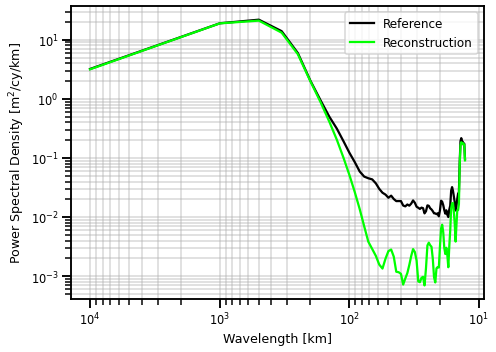

In [58]:
fig, ax = plot_psd_spectrum(psd_study, psd_ref, wavenumber)


wandb.log(
    {
        "model_psd_spectrum": wandb.Image(fig),
    }
)

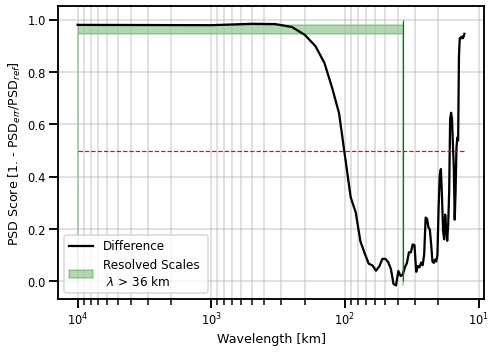

In [59]:
fig, ax = plot_psd_score(psd_diff, psd_ref, wavenumber, resolved_scale)

wandb.log(
    {
        "model_psd_score": wandb.Image(fig),
    }
)

In [60]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error

In [61]:
# mae = mean_absolute_error(data_test["sla_unfiltered"].values, data_test["pred"].values)
# mse = mean_squared_error(data_test["sla_unfiltered"].values, data_test["pred"].values)
# rmse = np.sqrt(mse)

# wandb.log(
#     {
#         "test_mae": mae,
#         "test_mse": mse,
#         "rmse": rmse,
#     }
# )

## Model States

## Visualize

In [62]:
if dataset == "ssh_gulf_winter":
    img_model = xr.open_dataset("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf_winter/model.nc")
elif dataset == "ssh_gulf_summer":
    img_model = xr.open_dataset("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf_summer/model.nc")
elif dataset == "ssh_gulf":
    img_model = xr.open_dataset("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf/model.nc")
else:
    raise ValueError(f"Unrecognized dataset: {dataset}")

img_model

<xarray.Dataset>
Dimensions:    (latitude: 48, longitude: 48, time: 92)
Coordinates:
  * latitude   (latitude) float64 32.12 32.38 32.62 32.88 ... 43.38 43.62 43.88
  * longitude  (longitude) float64 294.1 294.4 294.6 294.9 ... 305.4 305.6 305.9
  * time       (time) datetime64[ns] 2015-12-01 2015-12-02 ... 2016-03-01
Data variables:
    sla        (time, latitude, longitude) float64 ...
    adt        (time, latitude, longitude) float64 ...
    sla_grad   (time, latitude, longitude) float64 ...
    sla_lap    (time, latitude, longitude) float64 ...
Attributes:
    FileType:      GRID_DOTS
    OriginalName:  dt_upd_global_merged_msla_h_20150101_20150101_20210409.nc
    CreatedBy:     pva_axp@node065.sis.cnes.fr
    CreatedOn:     09-APR-2021 17:15:56:000000
    title:         SSALTO/DUACS - DT MSLA - Merged Product - Up-to-date Globa...
    history:       2021/04/09 17:15:56 pva_axp@node065.sis.cnes.fr Import dep...

In [63]:
import pyinterp

def create_grids(ds: xr.DataArray, variable: str, is_circle=True):
    x_axis = pyinterp.Axis(ds["longitude"][:]%360., is_circle=is_circle)
    y_axis = pyinterp.Axis(ds["latitude"][:])
    z_axis = pyinterp.TemporalAxis(ds["time"][:].values)
    var = ds[variable][:]
    var = var.transpose("longitude", "latitude", "time")
    
    try:
        var[var.mask] = np.nan
    except AttributeError:
        pass
    
    grid = pyinterp.Grid3D(x_axis, y_axis, z_axis, var.values)
    
    del ds
    
    return x_axis, y_axis, z_axis, grid
    

In [64]:
# create grids
grids = create_grids(img_model, "sla")

# interpolate maps alongtracks
ssh_map_interp = pyinterp.trivariate(
    grids[-1],
    img_test["longitude"].values,
    img_test["latitude"].values,
    grids[2].safe_cast(img_test["time"].values),
    bounds_error=False
)



In [65]:
ssh_alongtrack = img_test["sla_unfiltered"].values
lon_alongtrack = img_test["longitude"].values
lat_alongtrack = img_test["latitude"].values
time_alongtrack = img_test["time"].values
# ssh_map_interp = img_test["pred"].values

# get and apply mask from map_interp & alongtrack on each dataset
msk1 = np.ma.masked_invalid(ssh_alongtrack).mask
msk2 = np.ma.masked_invalid(ssh_map_interp).mask
msk = msk1 + msk2


lon_alongtrack = np.ma.masked_where(msk, lon_alongtrack).compressed()
lat_alongtrack = np.ma.masked_where(msk, lat_alongtrack).compressed()
time_alongtrack = np.ma.masked_where(msk, time_alongtrack).compressed()
ssh_alongtrack = np.ma.masked_where(msk, ssh_alongtrack).compressed()
ssh_map_interp = np.ma.masked_where(msk, ssh_map_interp).compressed()

# select inside value (this is done to insure similar number of point in statistical comparison between methods)
indices = np.where(
    (lon_alongtrack >= img_test["longitude"].min().values+0.25) & 
    (lon_alongtrack <= img_test["longitude"].max().values-0.25) &
    (lat_alongtrack >= img_test["latitude"].min().values+0.25) & 
    (lat_alongtrack <= img_test["latitude"].max().values-0.25)
)[0]


lon_alongtrack = lon_alongtrack[indices]
lat_alongtrack = lat_alongtrack[indices]
time_alongtrack = time_alongtrack[indices]
ssh_alongtrack = ssh_alongtrack[indices]
ssh_map_interp = ssh_map_interp[indices]

### NOTE

Seems to be a discrepency between how we interpolate the values

In [66]:
img_test["sla_unfiltered"].values.shape, ssh_map_interp.shape

((51551,), (47120,))

#### Stats

In [67]:
# calculate the (normalized) RMSE
ts_stats = calculate_nrmse(
    ssh_alongtrack, 
    ssh_map_interp, 
    time_alongtrack, 
    dt_freq=bin_time_step, 
    min_obs=min_obs
)


wandb.log(
    {
        "duacs_rmse_mean": ts_stats[0],
        "duacs_rmse_std": ts_stats[1],
        "duacs_rmse_mean": ts_stats[2],
        "duacs_nrmse_std": ts_stats[3],
    }
)
ts_stats

(0.03836299635111586,
 0.005750361661884541,
 0.8461252276981835,
 0.03142715445758047)

In [68]:
ssh_map_interp.shape

(47120,)

In [69]:
# compute along track segments
tracks = select_track_segments(
    time_alongtrack,
    lat_alongtrack,
    lon_alongtrack,
    ssh_alongtrack,
    ssh_map_interp,
)

# compute scores
wavenumber, psd_ref, psd_study, psd_diff, resolved_scale = compute_psd_scores(
    ssh_true=tracks[2],
    ssh_pred=tracks[3],
    delta_x=delta_x,
    npt=tracks[-1],
    scaling="density", 
    noverlap=0
)


# wandb.log(
#     {
#         "resolved_spatial_scale": resolved_scale,
#     }
# )

/home/johnsonj/projects/gps4oi/notebooks/nerf/src/psd.py:16: RuntimeWarning: divide by zero encountered in true_divide
  y = 1. / wavenumber


In [70]:
wavenumber[0] += 1e-4

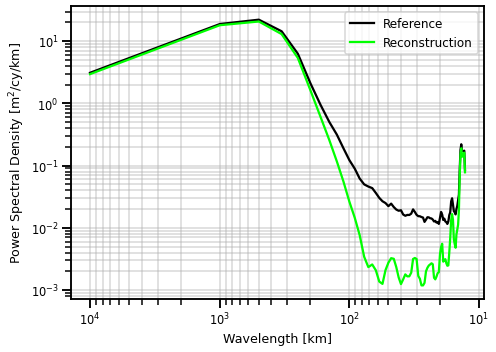

In [71]:
fig, ax = plot_psd_spectrum(psd_study, psd_ref, wavenumber)

wandb.log(
    {
        "duacs_psd_spectrum": wandb.Image(fig),
    }
)

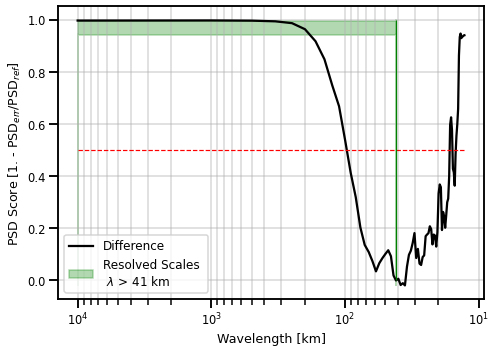

In [72]:
fig, ax = plot_psd_score(psd_diff, psd_ref, wavenumber, resolved_scale)

wandb.log(
    {
        "duacs_psd_score": wandb.Image(fig),
    }
)

In [73]:
%%time

# convert to dataframe
data_full = img_model.to_dataframe().reset_index().dropna()

CPU times: user 36 ms, sys: 8 ms, total: 44 ms
Wall time: 44.2 ms


In [74]:
wandb.config.update(
    {
        "n_duacs_domain": data_full.shape[0],
    }
)

In [75]:
data_full.shape

(210956, 7)

In [76]:
# # transform time coordinate
# days_in_year = 365
# year = pd.to_datetime(data_full['time']).dt.dayofyear
# data_full["doy_sin"] = np.sin(2.0 * np.pi * year / days_in_year)
# data_full["doy_cos"] = np.cos(2.0 * np.pi * year / days_in_year)
# data_full[cols] = time_scaler.transform(data_full[cols].values).squeeze()
# data_full.shape

In [77]:
data_full["time_julian"] = f(pd.DatetimeIndex(data_full['time']).to_julian_date())
data_full[cols] = time_scaler.transform(data_full[cols].values).squeeze()

In [78]:
%%time

data_full["pred"] = np.asarray(pred_step(model,jnp.asarray(data_full[cols].values)))

CPU times: user 5.32 s, sys: 264 ms, total: 5.58 s
Wall time: 1.56 s


In [79]:
data_full.head()

,latitude,longitude,time,sla,adt,sla_grad,sla_lap,time_julian,pred
0,-0.979229,-0.979361,2015-12-01,0.225685,0.844933,0.000731,0.052348,-1.000386,0.207052
1,-0.979229,-0.979361,2015-12-02,0.222328,0.841576,0.001277,0.013458,-0.978629,0.207416
2,-0.979229,-0.979361,2015-12-03,0.220970,0.840217,0.001641,0.009239,-0.956873,0.207501
3,-0.979229,-0.979361,2015-12-04,0.217335,0.836582,0.002273,0.004804,-0.935117,0.207230
4,-0.979229,-0.979361,2015-12-05,0.213086,0.832333,0.001955,0.017195,-0.913361,0.206568


In [80]:
ds = data_full.set_index(["time", "latitude", "longitude"]).to_xarray()

In [81]:
ds

<xarray.Dataset>
Dimensions:      (latitude: 48, longitude: 48, time: 92)
Coordinates:
  * time         (time) datetime64[ns] 2015-12-01 2015-12-02 ... 2016-03-01
  * latitude     (latitude) float64 -0.9792 -0.9376 -0.8959 ... 0.9375 0.9792
  * longitude    (longitude) float64 -0.9794 -0.9377 -0.896 ... 0.9375 0.9792
Data variables:
    sla          (time, latitude, longitude) float64 0.2257 0.2167 ... 0.08938
    adt          (time, latitude, longitude) float64 0.8449 0.8344 ... -0.1146
    sla_grad     (time, latitude, longitude) float64 0.0007315 ... 0.005626
    sla_lap      (time, latitude, longitude) float64 0.05235 0.03063 ... 0.00502
    time_julian  (time, latitude, longitude) float64 -1.0 -1.0 ... 0.9794 0.9794
    pred         (time, latitude, longitude) float32 0.2071 0.1852 ... 0.1399

In [82]:
ds.pred.min(), ds.pred.max(), ds.sla.min(), ds.sla.max()

(<xarray.DataArray 'pred' ()>
 array(-1.08446646),
 <xarray.DataArray 'pred' ()>
 array(1.01835299),
 <xarray.DataArray 'sla' ()>
 array(-1.001824),
 <xarray.DataArray 'sla' ()>
 array(0.921884))

In [83]:
ds.sla.hvplot.image(x="longitude", y="latitude", width=500, height=400, cmap="RdBu_r", title="Ground Truth")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (sla)

In [84]:
ds.pred.hvplot.image(x="longitude", y="latitude", width=500, height=400, cmap="RdBu_r", title="Predictions")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (pred)

## Fields

In [85]:
from src.viz import create_movie

In [86]:
# ds.p.hvplot.image(x="Nx", y="Ny", width=500, height=400, cmap="RdBu_r", title="Ground Truth")

In [87]:
create_movie(ds.sla, "truth", "time")
create_movie(ds.pred, "pred", "time")

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/92 [00:00<?, ?it/s]

Movie created at movie_truth.mp4
GIF created at plots/movie_truth.gif


/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/92 [00:00<?, ?it/s]

Movie created at movie_pred.mp4
GIF created at plots/movie_pred.gif


In [88]:
# ds.pred.hvplot.image(x="Nx", y="Ny", width=500, height=400, cmap="RdBu_r", title="Predictions")

In [89]:
wandb.log(
    {
        "ground_truth": wandb.Image("plots/movie_truth.gif"),
        "predictions": wandb.Image("plots/movie_pred.gif"),
    }
)

|**Ground Truth**| **Predictions** |
|:---:|:---|
| ![](plots/movie_truth.gif) | ![](plots/movie_pred.gif) |

### Calculate Gradients

In [90]:
ds["sla_grad"] = calculate_gradient(ds["sla"], "longitude", "latitude")
ds["pred_grad"] = calculate_gradient(ds["pred"], "longitude", "latitude")

In [91]:
# ds.sla_grad.hvplot.image(x="longitude", y="latitude", width=500, height=400, cmap="RdBu_r", title="Predictions")

In [92]:
# ds.pred_grad.hvplot.image(x="longitude", y="latitude", width=500, height=400, cmap="RdBu_r", title="Predictions")

In [93]:
create_movie(ds.sla_grad, "true_grad", "time", cmap="RdBu_r")
create_movie(ds.pred_grad, "pred_grad", "time", cmap="RdBu_r")

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/92 [00:00<?, ?it/s]

Movie created at movie_true_grad.mp4
GIF created at plots/movie_true_grad.gif


/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/92 [00:00<?, ?it/s]

Movie created at movie_pred_grad.mp4
GIF created at plots/movie_pred_grad.gif


In [94]:
wandb.log(
    {
        "ground_truth_grad": wandb.Image("plots/movie_true_grad.gif"),
        "predictions_grad": wandb.Image("plots/movie_pred_grad.gif"),
    }
)

|**Ground Truth**| **Predictions** |
|:---:|:---|
| ![](plots/movie_true_grad.gif) | ![](plots/movie_pred_grad.gif) |

#### Laplacian

In [95]:
ds["sla_lap"] = calculate_laplacian(ds["sla"], "longitude", "latitude")
ds["pred_lap"] = calculate_laplacian(ds["pred"], "longitude", "latitude")

In [96]:
# ds.sla_lap.hvplot.image(x="longitude", y="latitude", width=500, height=400, cmap="RdBu_r", title="Predictions")

In [97]:
# ds.pred_lap.hvplot.image(x="longitude", y="latitude", width=500, height=400, cmap="RdBu_r", title="Predictions")

In [98]:
create_movie(ds.sla_lap, "true_lap", "time", cmap="RdBu_r")
create_movie(ds.pred_lap, "pred_lap", "time", cmap="RdBu_r")

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/92 [00:00<?, ?it/s]

Movie created at movie_true_lap.mp4
GIF created at plots/movie_true_lap.gif


/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/92 [00:00<?, ?it/s]

Movie created at movie_pred_lap.mp4
GIF created at plots/movie_pred_lap.gif


In [99]:
wandb.log(
    {
        "ground_truth_laplacian": wandb.Image("plots/movie_true_lap.gif"),
        "predictions_laplacian": wandb.Image("plots/movie_pred_lap.gif"),
    }
)

|**Ground Truth**| **Predictions** |
|:---:|:---|
| ![](plots/movie_true_lap.gif) | ![](plots/movie_pred_lap.gif) |

### Errors

In [100]:
ds["err_abs"] = np.abs(ds["sla"] - ds["pred"])
ds["err_sq"] = (ds["sla"] - ds["pred"])**2
ds["err_rsq"] = np.sqrt((ds["sla"] - ds["pred"])**2)

In [101]:
create_movie(ds.err_abs, "err_abs", "time", cmap="viridis")
create_movie(ds.err_sq, "err_sq", "time", cmap="viridis")
create_movie(ds.err_rsq, "err_rsq", "time", cmap="viridis")

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/92 [00:00<?, ?it/s]

Movie created at movie_err_abs.mp4
GIF created at plots/movie_err_abs.gif


/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/92 [00:00<?, ?it/s]

Movie created at movie_err_sq.mp4
GIF created at plots/movie_err_sq.gif


/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/92 [00:00<?, ?it/s]

Movie created at movie_err_rsq.mp4
GIF created at plots/movie_err_rsq.gif


In [102]:
wandb.log(
    {
        "err_abs": wandb.Image("plots/movie_err_abs.gif"),
        "err_sq": wandb.Image("plots/movie_err_sq.gif"),
        "err_rsq": wandb.Image("plots/movie_err_rsq.gif"),
    }
)

**Errors (Absolute Value)**

![](plots/movie_err_abs.gif)
# 
**Errors (Mean Squared)**

![](plots/movie_err_sq.gif)

**Errors (Root Mean Squared)**

![](plots/movie_err_rsq.gif)

## Interpolation

In [103]:
# ds.err_abs.hvplot.image(x="Nx", y="Ny", width=500, height=400, cmap="viridis", title="Error (Absolute)")

In [104]:
# ds.err_sq.hvplot.image(x="Nx", y="Ny", width=500, height=400, cmap="viridis", title="Error (Absolute)")

In [105]:
# ds.err_rsq.hvplot.image(x="Nx", y="Ny", width=500, height=400, cmap="viridis", title="Error (Absolute)")